<a href="https://colab.research.google.com/github/cmannnn/predict_future_sales/blob/main/predict_future_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# File descriptions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


itemcats_df - supplemental information about the items categories.

items_df - supplemental information about the items/products.

salestrain_df - the training set. Daily historical data from January 2013 to October 2015.

shops_df - supplemental information about the shops.

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.

# Imports and uploads

In [3]:
# imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import datetime as dt

#import specific sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold

#encoders, tested several of them
from sklearn.preprocessing import OrdinalEncoder # remove later, don't use this
from sklearn.preprocessing import LabelEncoder # remove later, don't use this
from sklearn.preprocessing import OneHotEncoder # probably don't use this, instead use pd.get_dummies
from sklearn.feature_extraction import FeatureHasher

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

from sklearn import linear_model

## Kaggle Imports 

In [4]:
#!pip install kaggle

In [5]:
# UPLOAD YOUR kaggle.json KEY HERE

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))


#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [6]:
# !kaggle competitions list

In [7]:
# !mkdir -p predict_future_sales

In [8]:
# UPLOAD 6 FILES HERE
# uploaded2 = files.upload()

In [9]:
#!cp test.csv predict_future_sales/
#!cp item_categories.csv predict_future_sales/
#!cp items.csv predict_future_sales/
#!cp sales_train.csv predict_future_sales/
#!cp sample_submission.csv predict_future_sales/
#!cp shops.csv predict_future_sales/
#!cp test.csv predict_future_sales/

# Importing All Predict Sales Data

In [10]:
#importing all the data frames
root_path='drive/MyDrive/Camp Jupyter/predict_future_sales_data/'
itemcats_df = pd.read_csv(root_path+"item_categories.csv", encoding= 'unicode_escape') #Item Categories
items_df = pd.read_csv(root_path+"items.csv", encoding= 'unicode_escape') # Items
salestrain_df = pd.read_csv(root_path+"sales_train.csv", encoding= 'unicode_escape') #Sales Data - Training
shops_df = pd.read_csv(root_path+"shops.csv", encoding= 'unicode_escape') # Shops
usd_rus_df=pd.read_csv(root_path+'USD-RUS.csv')

In [11]:
# sample submission dataframe
sample_df = pd.read_csv(root_path+'sample_submission.csv')

# test data frame
test_df = pd.read_csv(root_path+'test.csv')

# Data EDA

In [12]:
# creating a master list of all dataframes
df_list = [itemcats_df, items_df, salestrain_df, shops_df]

In [13]:
# creating a loop to print head, description, info, and null sum for each datafram in master list 
for df in df_list:
    print(f'DATAFRAME HEAD: {df.head()}')
    print('-----------------------')
    print(f'DATAFRAME DESCRIPTION: {df.describe()}')
    print('-----------------------')
    print(f'DATAFAME INFO: {df.info()}')
    print('-----------------------')
    print(f'DATAFRAME NULL SUM: {df.isnull().sum()}')
    print('------------------------------------------------------------------------------')

DATAFRAME HEAD:            item_category_name  item_category_id
0  PC - Headsets / Headphones                 0
1           Accessories - PS2                 1
2           Accessories - PS3                 2
3           Accessories - PS4                 3
4           Accessories - PSP                 4
-----------------------
DATAFRAME DESCRIPTION:        item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
DATAFAME INFO: None
-----------------------
DATAFRAME NULL SUM: i

In [14]:
for df in df_list:
    for col in df:
        print('-----------------------------------------------------------')
        print(f'The {col} column has the following number of unique values:')
        print(df[col].nunique())
        print(' ')

-----------------------------------------------------------
The item_category_name column has the following number of unique values:
84
 
-----------------------------------------------------------
The item_category_id column has the following number of unique values:
84
 
-----------------------------------------------------------
The item_name column has the following number of unique values:
22150
 
-----------------------------------------------------------
The item_id column has the following number of unique values:
22170
 
-----------------------------------------------------------
The item_category_id column has the following number of unique values:
84
 
-----------------------------------------------------------
The date column has the following number of unique values:
1034
 
-----------------------------------------------------------
The date_block_num column has the following number of unique values:
34
 
-----------------------------------------------------------
The shop

In [15]:
# checking itemcats_df column data types
itemcats_df.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [16]:
# checking item_df column data types
items_df.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [17]:
# checking salestrain_df data types
salestrain_df.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [18]:
# changing salestrain 'item_cnt_day' col from float64 -> int16
salestrain_df['item_cnt_day'] = pd.to_numeric(salestrain_df['item_cnt_day'], downcast='signed')

In [19]:
# changing salestrain 'date' col from object -> datetime
salestrain_df['date'] = pd.to_datetime(salestrain_df['date'])

In [20]:
shops_df.dtypes

shop_name    object
shop_id       int64
dtype: object

In [21]:
# the df info showed some items with negative price, check them here
salestrain_df[salestrain_df['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1


In [22]:
# this item is a game, released in 2013, so very unlikely that price is negative: change price to median price of this item in the same date_block_num
salestrain_df.loc[salestrain_df['item_price'] < 0, 'item_price'] = salestrain_df[(salestrain_df['item_price'] > 0) & (salestrain_df['date_block_num'] == 4) & (salestrain_df['item_id'] == 2973)]['item_price'].median()

In [23]:
salestrain_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


### Check Currency Conversion Data

Adding Sumeets idea of adding the RUS-USD conversion rate to the main dataframe

In [24]:
usd_rus_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-12-01,29.730000,29.730000,29.690001,29.700001,29.700001,0.0
1,2003-12-02,29.690001,29.700001,29.690001,29.690001,29.690001,0.0
2,2003-12-03,29.690001,29.690001,29.690001,29.690001,29.690001,0.0
3,2003-12-04,29.680000,29.680000,29.680000,29.680000,29.680000,0.0
4,2003-12-05,29.629999,29.629999,29.629999,29.620001,29.620001,0.0


Text(0.5, 1.0, 'USD RUS exchange rate')

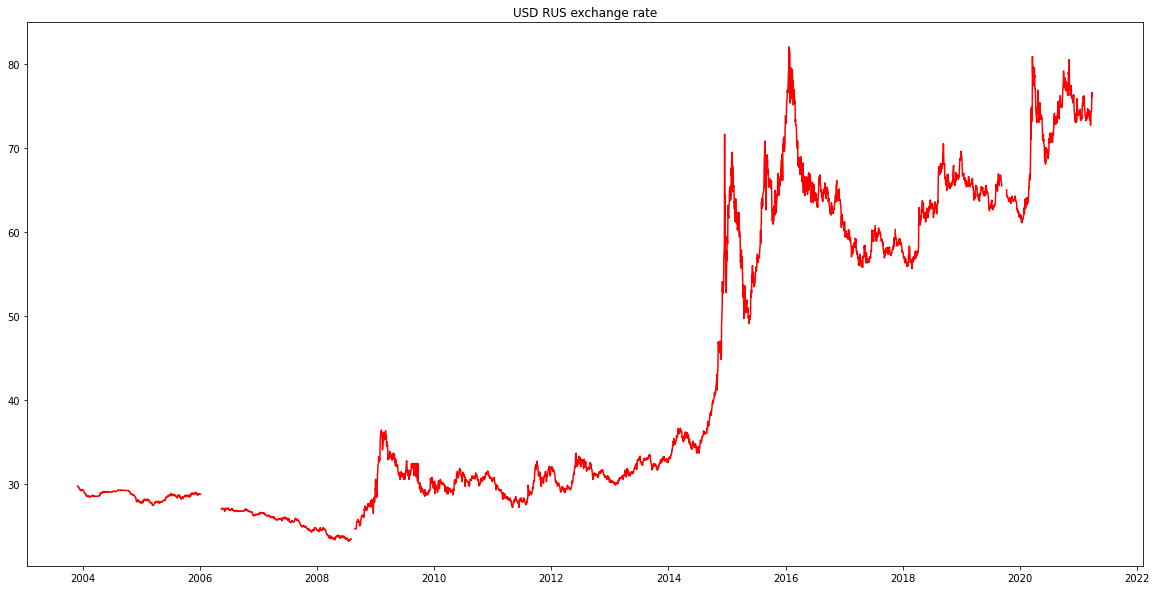

In [25]:
# plotting the exchange rate over time
# changing the date col to datetime
usd_rus_df.Date = pd.to_datetime(usd_rus_df.Date)
plt.figure(figsize = (20,10))
plt.plot(usd_rus_df.Date,usd_rus_df.Open, c = 'r')
plt.title('USD RUS exchange rate')

In [26]:
# merging exchange rate data to master dataframe
salestrain_df = salestrain_df.merge(usd_rus_df[['Date','Open']], left_on='date',right_on='Date')

In [27]:
salestrain_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Date,Open
0,2013-02-01,0,59,22154,999.0,1,2013-02-01,29.9816
1,2013-02-01,0,25,2565,549.0,1,2013-02-01,29.9816
2,2013-02-01,0,25,2546,299.0,1,2013-02-01,29.9816
3,2013-02-01,0,25,2715,899.0,1,2013-02-01,29.9816
4,2013-02-01,0,25,2716,149.0,1,2013-02-01,29.9816


In [28]:
# dropping the duplicated date col from 
salestrain_df.drop(['Date'], axis = 'columns', inplace = True)

In [29]:
# renaming the 'Open' col to 'USD_RUS' from the USD RUS conversion dataframe
salestrain_df.rename({'Open':'USD_RUS'}, axis = 'columns', inplace = True)

In [30]:
# caltulating the price based on the conversion rate
salestrain_df['USD_Price'] = salestrain_df['item_price'] / salestrain_df['USD_RUS']

In [31]:
# adding new col to dataframe for year
salestrain_df['year'] = salestrain_df['date'].dt.year

In [32]:
# taking a look at the main dataframe head
salestrain_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,USD_RUS,USD_Price,year
0,2013-02-01,0,59,22154,999.0,1,29.9816,33.320437,2013
1,2013-02-01,0,25,2565,549.0,1,29.9816,18.311231,2013
2,2013-02-01,0,25,2546,299.0,1,29.9816,9.972783,2013
3,2013-02-01,0,25,2715,899.0,1,29.9816,29.985058,2013
4,2013-02-01,0,25,2716,149.0,1,29.9816,4.969715,2013


In [33]:
# removing one obvious outlier
salestrain_df = salestrain_df[salestrain_df['item_price'] < 100000]

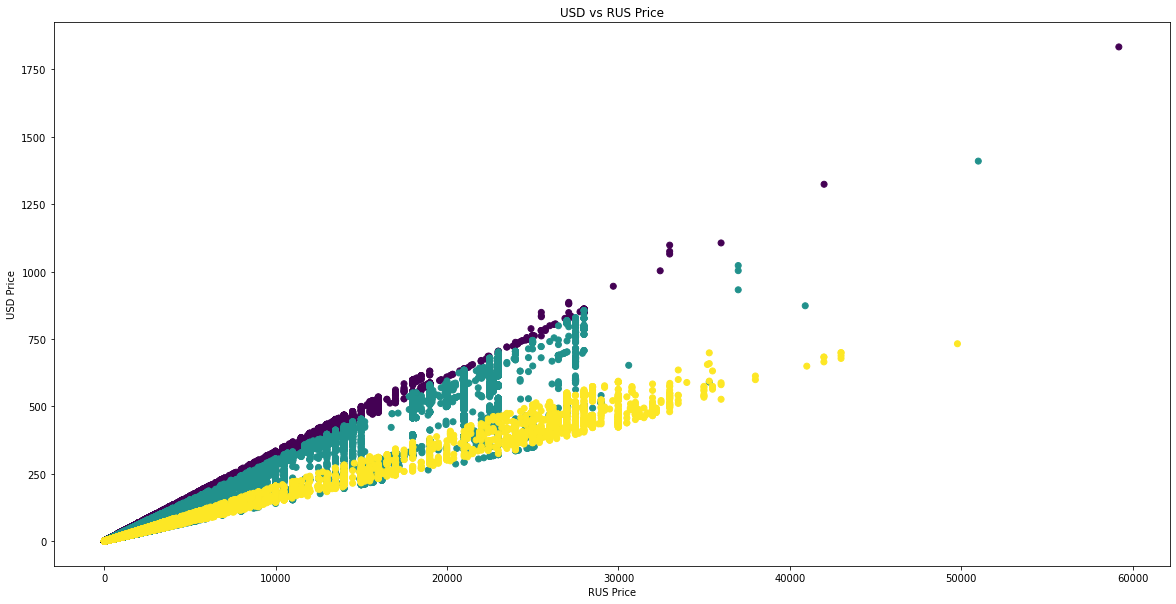

In [34]:
# USD vs RUS prices
plt.figure(figsize = (20, 10))
plt.scatter(salestrain_df.item_price,salestrain_df.USD_Price, c = salestrain_df.year)
plt.title('USD vs RUS Price')
plt.xlabel('RUS Price')
plt.ylabel('USD Price')
plt.show()

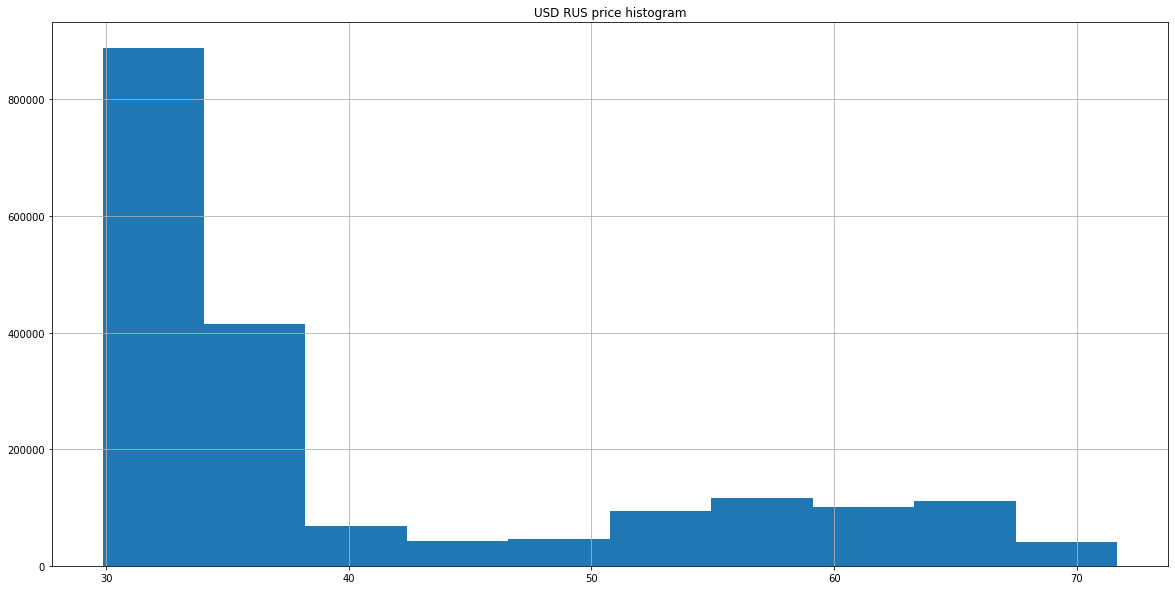

In [35]:
# USD vs RUS price histogram
plt.figure(figsize=(20, 10))
plt.title('USD RUS price histogram')
salestrain_df.USD_RUS.hist()

# Combine DFs

In [36]:
# combining training dataframes into master training set
salestrain_df_combined = salestrain_df.merge(items_df, on = 'item_id')
salestrain_df_combined = salestrain_df_combined.merge(itemcats_df, on = 'item_category_id')
salestrain_df_combined = salestrain_df_combined.merge(shops_df, on = 'shop_id')

In [37]:
# some missing USD RUS exchange rate data - ok to leave for now
salestrain_df_combined.isnull().sum()

date                     0
date_block_num           0
shop_id                  0
item_id                  0
item_price               0
item_cnt_day             0
USD_RUS               3871
USD_Price             3871
year                     0
item_name                0
item_category_id         0
item_category_name       0
shop_name                0
dtype: int64

In [38]:
# setting the id col, and 2 target cols based on testing data
id_col, target_col_item, target_col_shop = salestrain_df.index, salestrain_df_combined['item_id'], salestrain_df_combined['shop_id']

# Outliers
Based on the information from salestrain_df, the max price of some items is insanely high. In addition, quantity of items sold on one day is extremely high for some items. These particular rows are investigated in more detail.

Text(0.5, 1.0, 'Boxplot for checking outliers for number of items sold per day')

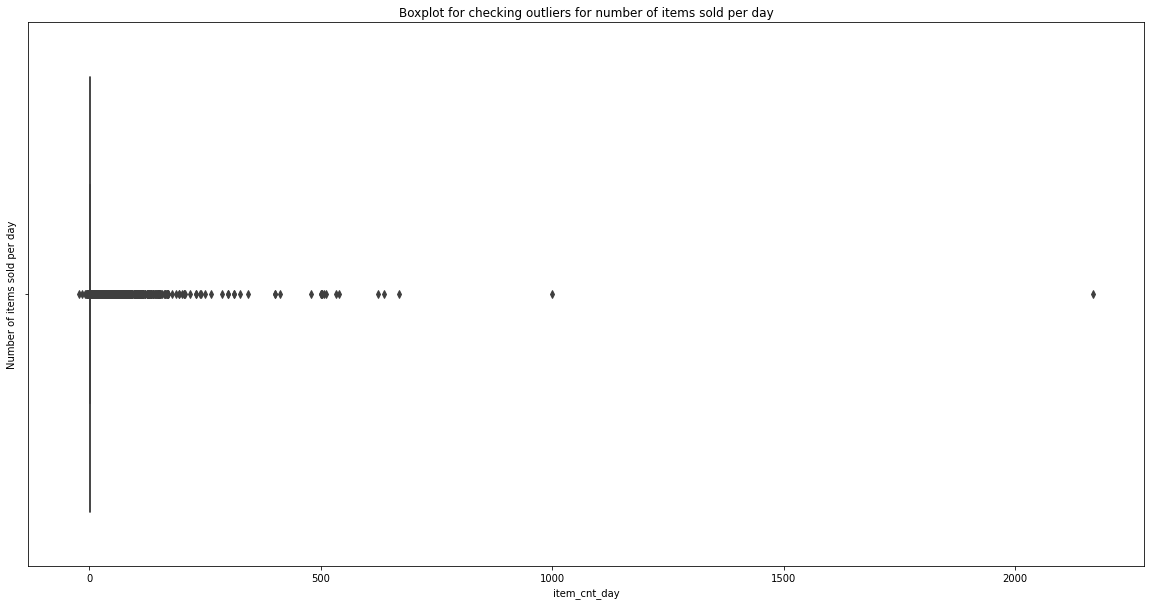

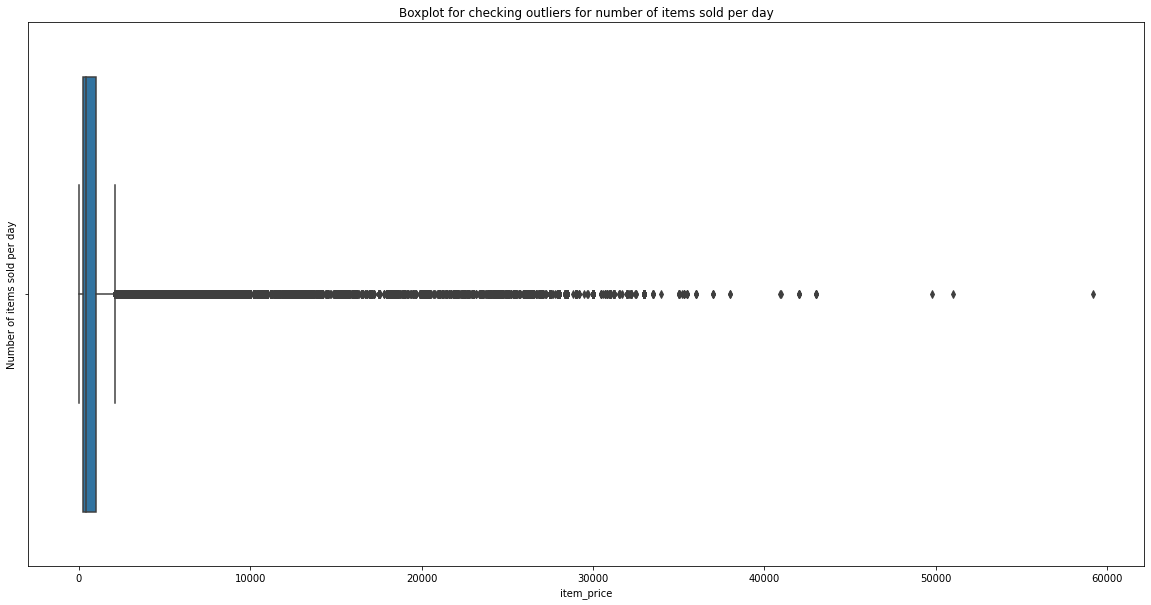

In [39]:
# checking outliers for quantity of items sold per day
plt.figure(figsize = (20, 10))
sns.boxplot(x=salestrain_df_combined['item_cnt_day'])
plt.ylabel('Number of items sold per day')
plt.title('Boxplot for checking outliers for number of items sold per day')

# checking outliers for item prices
plt.figure(figsize = (20, 10))
sns.boxplot(x=salestrain_df_combined['item_price'])
plt.ylabel('Number of items sold per day')
plt.title('Boxplot for checking outliers for number of items sold per day')

In [40]:
# boxplot shows quantity for 1 particular sale is very high. Check all sales where quantity is bigger than 500
# can imagine that one shop has 2169 deliveries at some peak days or some companies buying 1000 t-shirts
salestrain_df_combined[salestrain_df_combined['item_cnt_day'] > 500]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,USD_RUS,USD_Price,year,item_name,item_category_id,item_category_name,shop_name
1049046,2014-04-22,15,27,8057,1200.000000,502,35.667198,33.644359,2014,iTunes 1500 rubles.,32,"Payment card (Movies, Music, Games)","Moscow shopping center ""MEGA Belaya Dacha II"""
1597543,2015-04-14,27,12,3731,1904.548077,624,52.481701,36.289755,2015,"Grand Theft Auto V [PC, Russian subtitles]",30,Games PC - Standard Edition,Shop Online Emergencies
1613837,2015-01-15,24,12,20949,4.000000,1000,63.365799,0.063126,2015,Corporate package white shirt 1C Interest (34 ...,71,"Gifts - Bags, Albums, Mats d / mouse",Shop Online Emergencies
1615767,2015-05-19,28,12,11373,155.192950,539,49.084999,3.161719,2015,Delivery to the delivery point (Boxberry),9,Delivery of goods,Shop Online Emergencies
1615868,2015-10-28,33,12,11373,0.908714,2169,64.975998,0.013985,2015,Delivery to the delivery point (Boxberry),9,Delivery of goods,Shop Online Emergencies
1618032,2014-02-10,21,12,9242,1500.000000,512,34.685299,43.245987,2014,"Ticket ""IgroMir 2014"" (for one day (separately...",8,Tickets (digits),Shop Online Emergencies
1618890,2015-09-29,32,12,9248,1500.000000,504,66.099998,22.692890,2015,"Ticket ""IgroMir 2015"" - October 3, 2015 (site)...",80,Utilities - Tickets,Shop Online Emergencies
1618901,2015-09-30,32,12,9248,1692.526158,669,65.800003,25.722281,2015,"Ticket ""IgroMir 2015"" - October 3, 2015 (site)...",80,Utilities - Tickets,Shop Online Emergencies
1914217,2014-09-10,21,55,19437,899.000000,508,37.032200,24.276170,2014,"Middle-earth: Shadow of Mordor [PC, Digital Ve...",31,Games PC - Digital,Digital storage 1C-line
1925402,2015-09-29,32,55,9249,1500.000000,533,66.099998,22.692890,2015,"Ticket ""IgroMir 2015"" - October 3, 2015 (websi...",8,Tickets (digits),Digital storage 1C-line


In [41]:
# boxplot shows price for one item is very high, check all items above 40000
# most expensive item is a license for some software package (VPN remote working) for 522 users (roughly 4000 US dollars)
salestrain_df_combined[salestrain_df_combined['item_price'] > 40000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,USD_RUS,USD_Price,year,item_name,item_category_id,item_category_name,shop_name
142635,2014-03-20,14,25,13199,50999.0,1,36.170200,1409.972851,2014,Collector chess (Rings),69,Gifts - Souvenirs,"Moscow SEC ""Atrium"""
654062,2015-10-23,33,42,13403,42990.0,1,62.474998,688.115268,2015,"Set ""Microsoft Xbox One 1TB Limited Edition Ha...",16,Game consoles - XBOX ONE,"St. Petersburg TK ""Nevsky Center"""
891947,2015-10-22,33,28,13403,40991.0,1,63.150002,649.105284,2015,"Set ""Microsoft Xbox One 1TB Limited Edition Ha...",16,Game consoles - XBOX ONE,"Moscow shopping center ""MEGA Teply Stan"" II of"
1220560,2015-10-20,33,3,13403,42990.0,1,61.492001,699.115321,2015,"Set ""Microsoft Xbox One 1TB Limited Edition Ha...",16,Game consoles - XBOX ONE,"Balashikha TRC ""October-Kinomir"""
1599219,2013-10-24,9,12,7238,42000.0,1,31.720900,1324.048183,2013,UserGate Proxy & Firewall 6.X to 100 sessions,75,Program - For home and office,Shop Online Emergencies
1599254,2014-11-20,22,12,14173,40900.0,1,46.839199,873.200244,2014,License 1C-Bitrix Site Manager - Expert,75,Program - For home and office,Shop Online Emergencies
1599259,2015-01-29,24,12,7241,49782.0,1,67.985001,732.249750,2015,UserGate Proxy & Firewall 6.X filtration modul...,75,Program - For home and office,Shop Online Emergencies
1614386,2013-09-17,8,12,11365,59200.0,1,32.284100,1833.720005,2013,Delivery (EMS),9,Delivery of goods,Shop Online Emergencies
1618170,2015-10-20,33,12,13403,41990.0,1,61.492001,682.853043,2015,"Set ""Microsoft Xbox One 1TB Limited Edition Ha...",16,Game consoles - XBOX ONE,Shop Online Emergencies
1618171,2015-10-29,33,12,13403,42990.0,1,63.424999,677.808446,2015,"Set ""Microsoft Xbox One 1TB Limited Edition Ha...",16,Game consoles - XBOX ONE,Shop Online Emergencies


In [42]:
# for now, remove the row with the license for software package and any sale with quantity more or equal to 1000, discuss this next meeting
salestrain_df_combined = salestrain_df_combined[(salestrain_df_combined['item_cnt_day'] < 1000) & (salestrain_df_combined['item_price'] < 300000)]

# Data Viz

In [43]:
# adding features for separating date
salestrain_df_combined['year'] = salestrain_df_combined.date.dt.year
salestrain_df_combined['month'] = salestrain_df_combined.date.dt.month
salestrain_df_combined['day'] = salestrain_df_combined.date.dt.day

# adding revenue feature
salestrain_df_combined['revenue'] = salestrain_df_combined.item_price * salestrain_df_combined.item_cnt_day
salestrain_df_combined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,USD_RUS,USD_Price,year,item_name,item_category_id,item_category_name,shop_name,month,day,revenue
0,2013-02-01,0,59,22154,999.0,1,29.981600,33.320437,2013,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2,1,999.0
1,2013-02-13,1,59,16451,499.0,1,29.994400,16.636439,2013,Cloud Atlas (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2,13,499.0
2,2013-10-02,1,59,16451,499.0,1,32.230400,15.482278,2013,Cloud Atlas (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",10,2,499.0
3,2013-06-06,5,59,16451,199.0,1,32.109200,6.197601,2013,Cloud Atlas (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",6,6,199.0
4,2013-07-29,6,59,16451,199.0,1,32.744801,6.077301,2013,Cloud Atlas (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",7,29,199.0


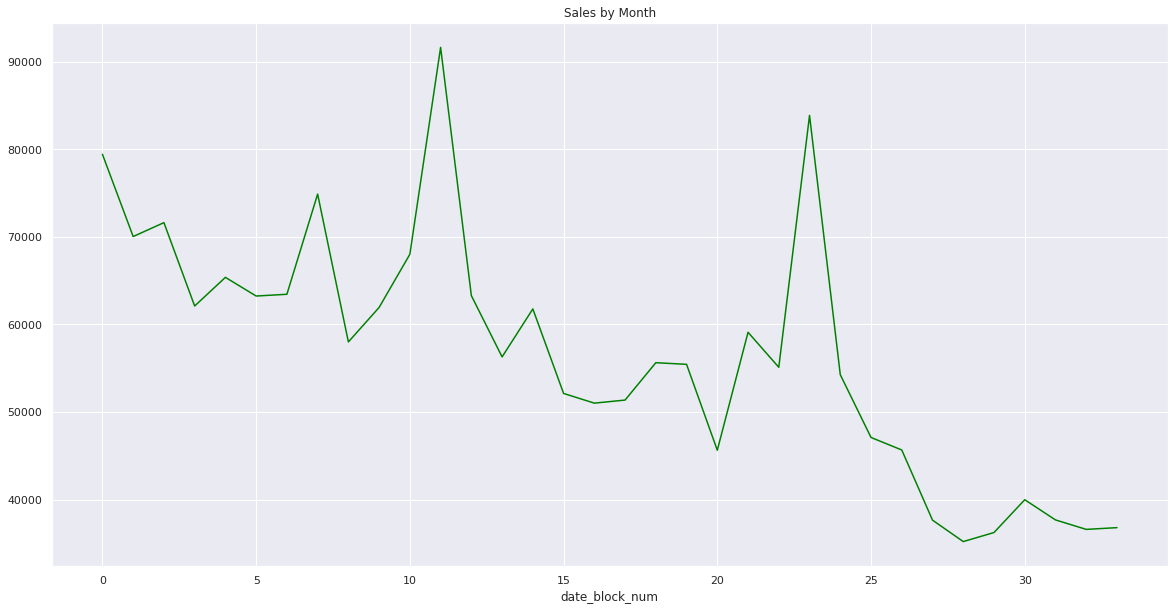

In [44]:
sns.set()
salestrain_df_combined.groupby('date_block_num').date.count().plot.line(title='Sales by Month', color='green', figsize=(20, 10))

As we can see, sales are decreasing through the years. 
We also see a spike sale during december. 
Since, the dataset is up to October, are we seeing some spike in year 2015?

In [ ]:
# time series scatterplot of revenue highlighting years
plt.figure(figsize = (20, 10))
sns.scatterplot(x = salestrain_df_combined['date'], y = salestrain_df_combined['revenue'], hue = salestrain_df_combined['year'], palette='deep')
plt.ylim(salestrain_df_combined['revenue'].min(), 1900000)
#plt.arrow(2013-11-29, 1829990.0000013, 2013-11-30, 1700000, head_width = 10, head_length = 11)
#plt.axvline()
plt.ylabel('Revenue (millions of rubles)')
plt.legend(fontsize='x-large')
plt.show()

In [ ]:
# printing most amount of revenue and least amount of revenue
print(f'The least amount of revenue recorded is: {salestrain_df_combined.revenue.min()}')
print(f'The most amount of revenue recorded is: {salestrain_df_combined.revenue.max()}')

In [ ]:
# day with the highest amount of revenue
print('The date with the most amount of revenue is:', salestrain_df_combined.loc[salestrain_df_combined['revenue'] == 734571.99999936, 'date'].values[0])

In [ ]:
# masking revenue numbers to show negative revenue
# not sure how to have negative revenue
# item returns?
salestrain_neg_mask = salestrain_df_combined['revenue'] < 0
salestrain_df_combined[salestrain_neg_mask].head(10)

In [ ]:
# grouping revenue by month and rounding number
monthly_group = salestrain_df_combined.groupby(by=['month'])
monthly_group_sum = monthly_group['revenue'].sum().round()      
monthly_group_sum                   

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x = salestrain_df_combined['item_price'], y = salestrain_df_combined['USD_Price'], hue = salestrain_df_combined['year'], palette='deep')

In [ ]:
# normalizing data for visualization
monthly_group_norm = (monthly_group_sum - monthly_group_sum.mean()) / (monthly_group_sum.max() - monthly_group_sum.min())
monthly_group_norm = abs(monthly_group_norm)
monthly_group_norm

In [ ]:
# graphing normalized revenue
# look at those december sales!!
ax, fig = plt.subplots(figsize=(20,10))
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(cols, monthly_group_norm, color='red')
plt.title('Normalized revenue by month')
plt.show()

In [ ]:
# Plot total revenue by month for each year
salestrain_df_combined.groupby(['month', 'year']).sum()['revenue'].unstack().plot(figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

There are no sales spike on december 2015.

In [ ]:
# creating list of top selling items
top_items = [20949, 5822, 17717, 2808, 4181, 7856, 3732, 2308, 4870, 3734]

# creating empty list to append to
top_item_cols = []

# loop to append item name based on top selling items
for items in top_items:
  top_item_cols.append(salestrain_df_combined.loc[salestrain_df_combined['item_id'] == items, 'item_name'].values[0])

top_item_cols

In [ ]:
# Plot the top 10 most items sold
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(y = 'item_id', hue = 'year', data = salestrain_df_combined, order = salestrain_df_combined['item_id'].value_counts().iloc[:10].index)
ax.set_yticklabels(top_item_cols)
plt.xlim(0, 20000)
plt.xlabel('Sales of Sold Items')
plt.ylabel('Item IDs')
plt.show()

In [ ]:
salestrain_df_combined['item_id'] == 20949

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(salestrain_df_combined.corr(), cmap='Blues')
plt.show()

In [ ]:
# plotting histogram of the price of items
# some high ticket items, lots 
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='item_price', data=salestrain_df)
plt.xlim(0, 4000)
plt.title('Item price histogram')
plt.show()

In [ ]:
test_df.head()

In [ ]:
sample_df.head()

# Lagging Features



*   Item Sales Lag (1,2,3,6,12 months)
*   Combination of Items and Shops
*   Shop Sales Lag
*   Shop-Category Lag



In [ ]:
# creating a new feature: 'month-year'
salestrain_df_combined['month-year'] = salestrain_df_combined['date'].apply(lambda x: str(x.month) + '-' + str(x.year) if x.month >= 10 else '0' + str(x.month) + '-' + str(x.year)) 

In [ ]:
salestrain_df_combined.head()

In [ ]:
# adding a random feature
salestrain_df_combined['Random'] = salestrain_df_combined.apply(lambda x:np.random.randint(100),axis='columns')

In [ ]:
salestrain_df_combined.head()

In [ ]:
# creating pivot table on 'month' and 'year' columns
item_sales_by_month = salestrain_df_combined.pivot_table(index = 'item_id', columns = ['month', 'year'], values = 'item_cnt_day', aggfunc = np.sum)

In [ ]:
# filling in all null values with 0
item_sales_by_month.fillna(0, inplace = True)

In [ ]:
# checking head of the pivot table
item_sales_by_month.head()

There were two sales of item id 1 in month 4 of year 2014

In [ ]:
# unstacking the pivot table above and resetting the index
item_sales_by_month = item_sales_by_month.unstack().reset_index()

In [ ]:
# checking new df head - note strange 0 column
item_sales_by_month.head()

In [ ]:
# renaming strange 0 columm to 'Item_Sales_This_Month?' - need clarification on column name
item_sales_by_month.rename({0:'Item_Sales_This_Month'}, axis = 'columns', inplace = True)

In [ ]:
# sorting table by item_id then year then month
item_sales_by_month.sort_values(by = ['item_id','year','month'], inplace = True)

In [ ]:
# checking modified df
item_sales_by_month.head()

In [ ]:
# length before cutting out all 0's
len(item_sales_by_month)

In [ ]:
item_sales_by_month = item_sales_by_month[item_sales_by_month.Item_Sales_This_Month > 0]

In [ ]:
# length after cutting out all 0's
len(item_sales_by_month)

In [ ]:
# cutting out all 0's decreases dataframe by 1/3
255105 / 758124 

In [ ]:
# creating new column lags for 1, 2, 3, 6, 12 months
for i in [1,2,3,6,12]:
  item_sales_by_month[str(i)+'_month_ago'] = item_sales_by_month['Item_Sales_This_Month'].shift(i)

In [ ]:
# checking newly added lags on item id '22167' because it has a lot of sales and we can see values clearly
item_sales_by_month[item_sales_by_month.item_id == 22167].head(13)

In [78]:
item_sales_by_month.head(30)

,month,year,item_id,Item_Sales_This_Month,1_month_ago,2_month_ago,3_month_ago,6_month_ago,12_month_ago
21059,1,2014,0,1.0,NaN,NaN,NaN,NaN,NaN
84237,2,2014,1,1.0,1.0,NaN,NaN,NaN,NaN
210591,4,2014,1,2.0,1.0,1.0,NaN,NaN,NaN
589653,10,2014,1,1.0,2.0,1.0,1.0,NaN,NaN
716008,12,2014,2,1.0,1.0,2.0,1.0,NaN,NaN
273770,5,2014,3,1.0,1.0,1.0,2.0,NaN,NaN
463301,8,2014,3,1.0,1.0,1.0,1.0,1.0,NaN
526479,9,2014,4,1.0,1.0,1.0,1.0,1.0,NaN
21064,1,2014,8,1.0,1.0,1.0,1.0,2.0,NaN
463303,8,2014,8,1.0,1.0,1.0,1.0,1.0,NaN


In [ ]:
# Add item_id to shift, make values N/A if item_id!=laggy item_id
# Is there a better way to filter NaN values

In [90]:
item_id_by_month = salestrain_df_combined[['item_id', 'month', 'year', 'item_cnt_day']]

In [97]:
item_id_by_month.head()

,item_id,month,year,item_cnt_day
0,22154,2,2013,1
1,16451,2,2013,1
2,16451,10,2013,1
3,16451,6,2013,1
4,16451,7,2013,1
...,...,...,...,...
1927067,13091,9,2015,1
1927068,13095,9,2015,1
1927069,13095,8,2015,1
1927070,13095,10,2015,2


In [96]:
item_id_by_month.groupby(['item_id', 'year', 'month'])

AttributeError: ignored

In [93]:
item_id_by_month.head()

,item_id,month,year,item_cnt_day
0,22154,2,2013,1
1,16451,2,2013,1
2,16451,10,2013,1
3,16451,6,2013,1
4,16451,7,2013,1
...,...,...,...,...
1927067,13091,9,2015,1
1927068,13095,9,2015,1
1927069,13095,8,2015,1
1927070,13095,10,2015,2


# Feature selection

Make features for MA: 7, 30, 60, 90 days, season, month

Convert into categorical - Store, Item

In [ ]:
# item names with their revenue and sold count
item_names = salestrain_df_combined.groupby('item_name').agg({'revenue':'sum', 'item_cnt_day':'count'}).reset_index().rename(columns={'item_name': 'Item Name', 'revenue': 'Revenue', 'item_cnt_day': 'Number of Sales'})
item_names.head()

,Item Name,Revenue,Number of Sales
0,! ABBYY FineReader 12 Professional Edition Ful...,26940.00,6
1,! POWER IN glamor (PLAST.) D,58.00,1
2,"""Grand BUDAPEST"" (BD)",295962.82,552
3,"""Grand Budapest""",403935.42,911
4,"""Operation Bagration» [PC, Digital Version]",9765.00,31


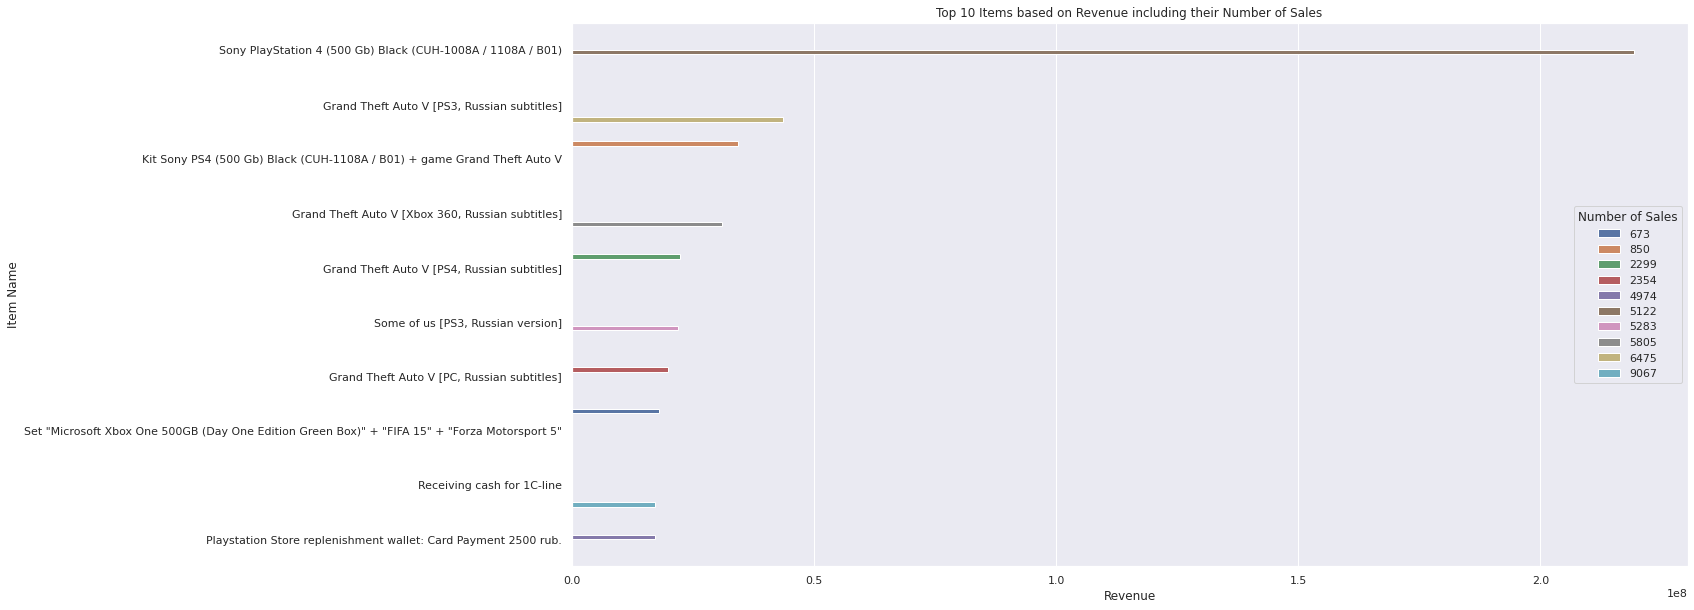

In [ ]:
# top 10 items based on their revenue
top10_revenue = item_names.nlargest(10, 'Revenue')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_revenue, hue='Number of Sales', x='Revenue', y='Item Name')
plt.title("Top 10 Items based on Revenue including their Number of Sales")
plt.show()

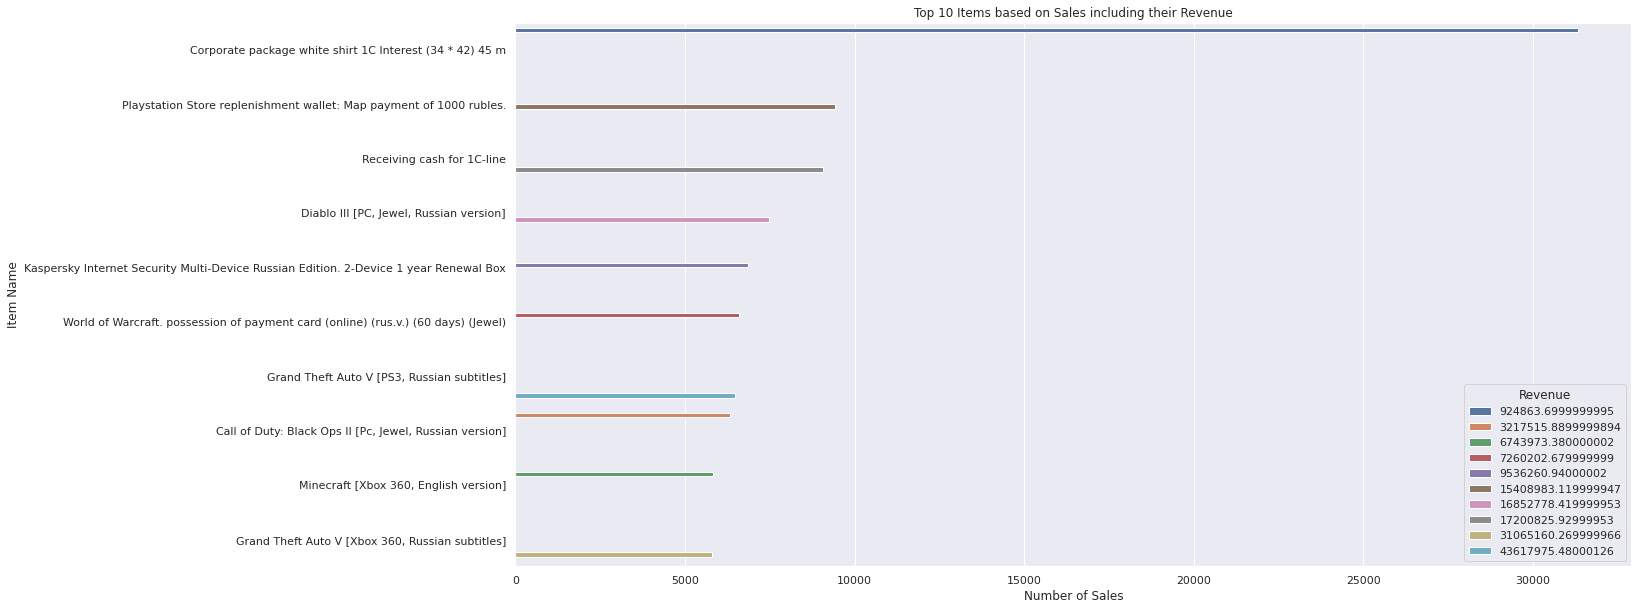

In [ ]:
# top 10 items based on their revenue
top10_sales = item_names.nlargest(10, 'Number of Sales')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_sales, x='Number of Sales', y='Item Name', hue='Revenue')
plt.title("Top 10 Items based on Sales including their Revenue")
plt.show()

In [ ]:
# category names and how many items in it.
category_names = salestrain_df_combined.groupby(['item_category_name']).agg({'item_name':'count'}).reset_index().rename(columns={'item_category_name': 'Category Name','item_name': 'Number of Items'})
category_names.head()

,Category Name,Number of Items
0,Accessories - PS2,2
1,Accessories - PS3,18461
2,Accessories - PS4,25283
3,Accessories - PSP,2304
4,Accessories - PSVita,7231


In [ ]:
#Find total sales by item
total_sales_by_item = salestrain_df_combined.groupby('item_id')['item_cnt_day'].sum().reset_index()

#Sort descending
total_sales_by_item.sort_values(by='item_cnt_day',ascending=False,inplace=True)
total_sales_by_item.head()

,item_id,item_cnt_day
20601,20949,186642.0
2749,2808,17245.0
3654,3732,16642.0
17417,17717,15830.0
5717,5822,14515.0


In [ ]:
#Merge together so we can get item_name with total sales values
total_sales_by_item_with_name = total_sales_by_item.merge(items_df[['item_name','item_id']],on='item_id')
total_sales_by_item_with_name.head()

,item_id,item_cnt_day,item_name
0,20949,186642.0,Corporate package white shirt 1C Interest (34 ...
1,2808,17245.0,"Diablo III [PC, Jewel, Russian version]"
2,3732,16642.0,"Grand Theft Auto V [PS3, Russian subtitles]"
3,17717,15830.0,Receiving cash for 1C-line
4,5822,14515.0,Playstation Store replenishment wallet: Map pa...


In [ ]:
total_sales_by_item['item_cnt_day'].iloc[:10]

20601    186642.0
2749      17245.0
3654      16642.0
17417     15830.0
5717      14515.0
3656      11688.0
6542      10289.0
3653      10099.0
1814      10032.0
16492      9227.0
Name: item_cnt_day, dtype: float64

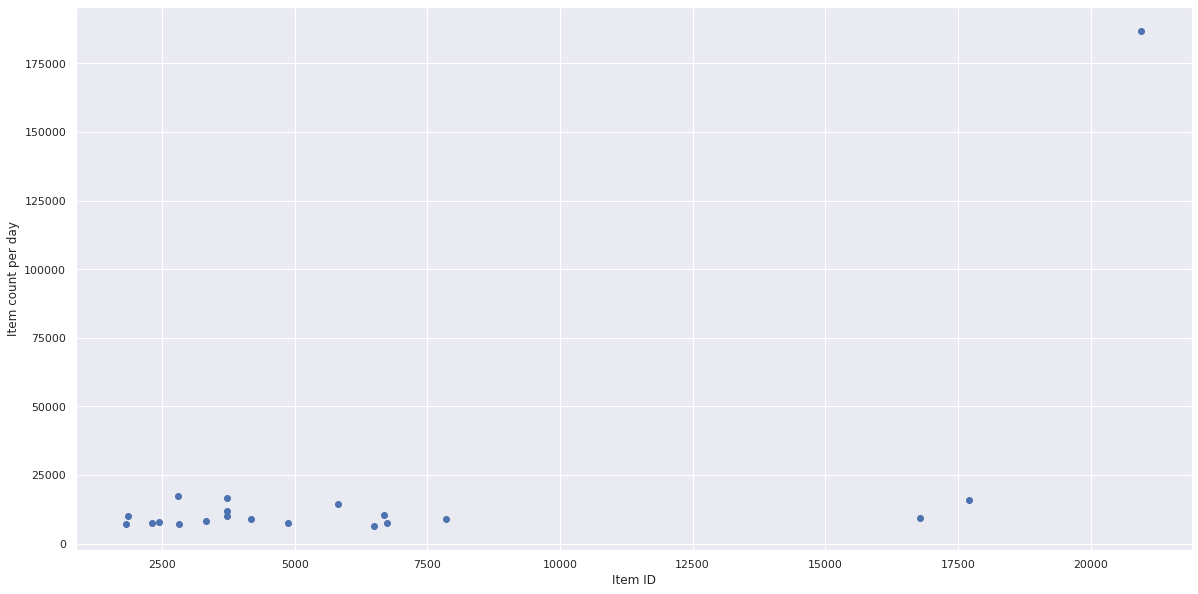

In [ ]:
# updated scatterplot showing top 20 best selling items day to day
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(y = total_sales_by_item['item_cnt_day'].iloc[:20], x = total_sales_by_item['item_id'].iloc[:20])
plt.xlabel('Item ID')
plt.ylabel('Item count per day')
plt.show()

## Recommendation Engine

In [ ]:
# Get sales by item, by date - again, not very exciting,so I also used fillna()
sales_totals_by_day = salestrain_df_combined.pivot_table(index='item_id',columns=['year', 'month', 'day'],values='item_cnt_day').fillna(0)

In [ ]:
# Clean up the multi-level index
sales_totals_by_day.columns = sales_totals_by_day.columns.droplevel().droplevel()

In [ ]:
sales_totals_by_day.head()

day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,1,2,3,4,5,6,7,8,9,...,10,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Shape of the resulting DF - items x days
sales_totals_by_day.shape

(21806, 1034)

In [ ]:
#Transpose this
sales_totals_by_day_transposed = sales_totals_by_day.transpose()

In [ ]:
sales_totals_by_day_transposed.head()

item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,22129,22130,22131,22132,22133,22134,22135,22136,22138,22139,22140,22141,22142,22143,22144,22145,22146,22147,22148,22149,22150,22151,22152,22153,22154,22155,22156,22157,22158,22159,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.166667,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.600000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.333333,1.0,1.0,1.428571,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.214286,1.1,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,1.0,1.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,1.000000,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Recommendation engine - find the closest matches to an item in terms of daily sales
# Similar to finding similar movies based on movie rating

#Select a popular item
selected_item = 2808

In [ ]:
#Pull out the column of that day's sales
selected_item_sales = sales_totals_by_day_transposed[selected_item]

In [ ]:
#Run correlation with every other column to find similar sales patterns
similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)

In [ ]:
#Convert from a series to a DF
similarItems_df = pd.DataFrame(similarItems)

In [ ]:
similarItems_df.head()

,0
item_id,
0,-0.005647
1,-0.019637
2,-0.011574
3,-0.005914
4,-0.008847


In [ ]:
#Rename columns
similarItems_df.columns=['similarity']

In [ ]:
similarItems_df.head()

,similarity
item_id,
0,-0.005647
1,-0.019637
2,-0.011574
3,-0.005914
4,-0.008847


In [ ]:
#Merge back item names
similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')

In [ ]:
#Sort
similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)

In [ ]:
#The top results for item 2808 seem to make some sense (games), but they also include programming books and other things-inconclusive?
similarItems_df_sorted.head(20)

,similarity,item_name,item_id
2808,1.000000,"Diablo III [PC, Jewel, Russian version]",2808
10956,0.489434,Django Unchained,10956
19149,0.477112,Stukachev (Paradis),19149
7100,0.445205,"Total War: Rome II (Pre-Order) [PC, Digital Ve...",7100
12571,0.423180,Fight fire,12571
13809,0.420981,LEGEND ? 17 (BD + DVD) + BD bouncer,13809
1476,0.416799,"Assassin's Creed 3. Washington [PC, Russian ve...",1476
16900,0.414021,PARKER,16900
19529,0.411316,Timeless. RUBY BOOK,19529
14429,0.403746,MASHA AND THE BEAR. GROWTH VITAMIN,14429


In [ ]:
#Function to return the values:

def find_similar_based_on_daily_sales(selected_item,sales_totals_by_day_transposed=sales_totals_by_day_transposed):
    selected_item_sales=sales_totals_by_day_transposed[selected_item]
    similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)
    similarItems_df=pd.DataFrame(similarItems)
    similarItems_df.columns=['similarity']
    similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')
    similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)
    print(similarItems_df_sorted.head(20))

In [ ]:
find_similar_based_on_daily_sales(2808)

       similarity                                          item_name  item_id
2808     1.000000            Diablo III [PC, Jewel, Russian version]     2808
10956    0.489434                                   Django Unchained    10956
19149    0.477112                                Stukachev (Paradis)    19149
7100     0.445205  Total War: Rome II (Pre-Order) [PC, Digital Ve...     7100
12571    0.423180                                         Fight fire    12571
13809    0.420981                LEGEND ? 17 (BD + DVD) + BD bouncer    13809
1476     0.416799  Assassin's Creed 3. Washington [PC, Russian ve...     1476
16900    0.414021                                             PARKER    16900
19529    0.411316                                Timeless. RUBY BOOK    19529
14429    0.403746                 MASHA AND THE BEAR. GROWTH VITAMIN    14429
16736    0.400455                                     Gangster Squad    16736
7250     0.393255  V / A A State Of Trance The Expidition Episod

In [ ]:
#What is similar to those corporate T-shirts?
find_similar_based_on_daily_sales(20949)

       similarity                                          item_name  item_id
20949    1.000000  Corporate package white shirt 1C Interest (34 ...    20949
4870     0.516483              Minecraft [Xbox 360, English version]     4870
972      0.486718        30 SECONDS TO MARS Love Lust Faith + Dreams      972
6498     0.484754  Sims 3: Island Paradise (addition) [PC, Russia...     6498
16169    0.469863  Board game Mafia whole family assembly (card g...    16169
15063    0.465117  Might and Magic. Heroes 6. The Edge of Darknes...    15063
21377    0.462729         The Hobbit: An Unexpected Journey (region)    21377
3183     0.449242  Elder Scrolls V: Skyrim Legendary Edition [PC,...     3183
20947    0.426141  Phineas and Ferb. Conquest of the second measu...    20947
6084     0.408180              Rayman Legends [PS3, Russian version]     6084
17754    0.408138  Journey. Collector's Edition [PS3, Russian doc...    17754
8686     0.407217                                            BAS

In [ ]:
#What is similar to minecraft?
find_similar_based_on_daily_sales(4870)

       similarity                                          item_name  item_id
4870     1.000000              Minecraft [Xbox 360, English version]     4870
4181     0.698090  Kaspersky Internet Security Multi-Device Russi...     4181
4178     0.658616  Kaspersky Internet Security Multi-Device Russi...     4178
3423     0.564589   Far Cry 3 (Classics) [Xbox 360, Russian version]     3423
21377    0.544731         The Hobbit: An Unexpected Journey (region)    21377
10659    0.541108  Puzzle Rubik's Cube 3x3 without labels, soft m...    10659
6498     0.525330  Sims 3: Island Paradise (addition) [PC, Russia...     6498
20949    0.516483  Corporate package white shirt 1C Interest (34 ...    20949
4904     0.515135  Mortal Kombat. Komplete Edition [PC, Jewel, Ru...     4904
10292    0.512199                                      DESPICABLE ME    10292
3183     0.509814  Elder Scrolls V: Skyrim Legendary Edition [PC,...     3183
6497     0.486503    Sims 3: Set for beginners [PC, Russian vers

In [ ]:
#This item averaged 5 sales per day, max of 35, so it wasn't distorted by one overwhelmingly high corporate order
sales_totals_by_day_transposed[20949].describe()

count    1034.000000
mean        5.068981
std         3.144437
min         0.000000
25%         3.670000
50%         4.690981
75%         6.367225
max        26.093023
Name: 20949, dtype: float64

## Rolling window K-fold cross-validation

In [ ]:
salestrain_df_combined.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'year', 'month', 'day', 'revenue'],
      dtype='object')

In [ ]:
# setting X as date col and y as revenue col to be split
X = salestrain_df_combined['date']
y = salestrain_df_combined['revenue']

In [ ]:
# creating the time series split, one split for every month in the year
tscv = TimeSeriesSplit(n_splits = 12)

In [ ]:
# looping through every time series split 
for train_index, test_index in tscv.split(X):
  print(f'TRAIN SHAPE: {train_index.shape} TEST SHAPE: {test_index.shape}')
    
  #X_train, X_test = X[train_index], X[test_index]
  #y_train, y_test = y[train_index], y[train_index]

TRAIN SHAPE: (225838,) TEST SHAPE: (225834,)
TRAIN SHAPE: (451672,) TEST SHAPE: (225834,)
TRAIN SHAPE: (677506,) TEST SHAPE: (225834,)
TRAIN SHAPE: (903340,) TEST SHAPE: (225834,)
TRAIN SHAPE: (1129174,) TEST SHAPE: (225834,)
TRAIN SHAPE: (1355008,) TEST SHAPE: (225834,)
TRAIN SHAPE: (1580842,) TEST SHAPE: (225834,)
TRAIN SHAPE: (1806676,) TEST SHAPE: (225834,)
TRAIN SHAPE: (2032510,) TEST SHAPE: (225834,)
TRAIN SHAPE: (2258344,) TEST SHAPE: (225834,)
TRAIN SHAPE: (2484178,) TEST SHAPE: (225834,)
TRAIN SHAPE: (2710012,) TEST SHAPE: (225834,)


## Removing features with low variance

In [ ]:
salestrain_df_combined.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'year', 'month', 'day', 'revenue'],
      dtype='object')

In [ ]:
train_set = salestrain_df_combined.drop(columns = ['revenue'])

In [ ]:
# mapping date col to ordinal for use with VarianceThreshold
train_set['date'] = train_set['date'].map(dt.datetime.toordinal)

In [ ]:
for col in ['item_name', 'item_category_name', 'shop_name']:
   train_set[col] = LabelEncoder().fit_transform(train_set[col])

In [ ]:
test_set = salestrain_df_combined['revenue']

In [ ]:
train_set.dtypes

date                    int64
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day            int16
item_name               int64
item_category_id        int64
item_category_name      int64
shop_name               int64
year                    int64
month                   int64
day                     int64
dtype: object

In [ ]:
test_set.shape

(2935846,)

In [ ]:
# creating the Variance Threshold and setting variance to 10 -> can mess around with this number
threshold = VarianceThreshold(threshold = 10)

In [ ]:
# fit transforming variance threshold to train set
high_variance = threshold.fit(train_set)

In [ ]:
# seeing which cols do not have high variance
train_set.columns[high_variance.get_support()]

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_name', 'item_category_id', 'item_category_name', 'shop_name',
       'month', 'day'],
      dtype='object')

In [ ]:
# seeing which cols have low variance
constant_cols = [column for column in train_set.columns if column not in train_set.columns[high_variance.get_support()]]
print(f'The columns with low(ish) variance is: {constant_cols}')

The columns with low(ish) variance is: ['item_cnt_day', 'year']


All of our features have high variance, therefore they don't have to be removed.

## K-Means clustering

In [ ]:
#salestrain_df.head()
salestrain_df = salestrain_df.drop('date', axis=1)

In [ ]:
salestrain_df.head(10)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,59,22154,999.00,1
1,0,25,2552,899.00,1
2,0,25,2552,899.00,-1
3,0,25,2554,1709.05,1
4,0,25,2555,1099.00,1
5,0,25,2564,349.00,1
6,0,25,2565,549.00,1
7,0,25,2572,239.00,1
8,0,25,2572,299.00,1
9,0,25,2573,299.00,3


In [ ]:
# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

# Fit the pipeline to samples
pipeline.fit(np.array(salestrain_df))

# Calculate the cluster labels: labels
labels = pipeline.predict(salestrain_df)

# Create a DataFrame with labels and prices as columns: salestrain_df
#salestrain_df = pd.DataFrame({'item_price': item_price, 'item_cnt_day': item_cnt_day})

# Create crosstab: ct
ct = pd.crosstab(salestrain_df['item_price'], salestrain_df['item_cnt_day'])

# Display ct
print(ct.sort_values('item_price'))

item_cnt_day  -22    -16    -9     -6     ...   637    669    1000   2169
item_price                                ...                            
0.0700            0      0      0      0  ...      0      0      0      0
0.0875            0      0      0      0  ...      0      0      0      0
0.0900            0      0      0      0  ...      0      0      0      0
0.1000            0      0      0      0  ...      0      0      0      0
0.2000            0      0      0      0  ...      0      0      0      0
...             ...    ...    ...    ...  ...    ...    ...    ...    ...
42990.0000        0      0      0      0  ...      0      0      0      0
49782.0000        0      0      0      0  ...      0      0      0      0
50999.0000        0      0      0      0  ...      0      0      0      0
59200.0000        0      0      0      0  ...      0      0      0      0
307980.0000       0      0      0      0  ...      0      0      0      0

[19992 rows x 198 columns]


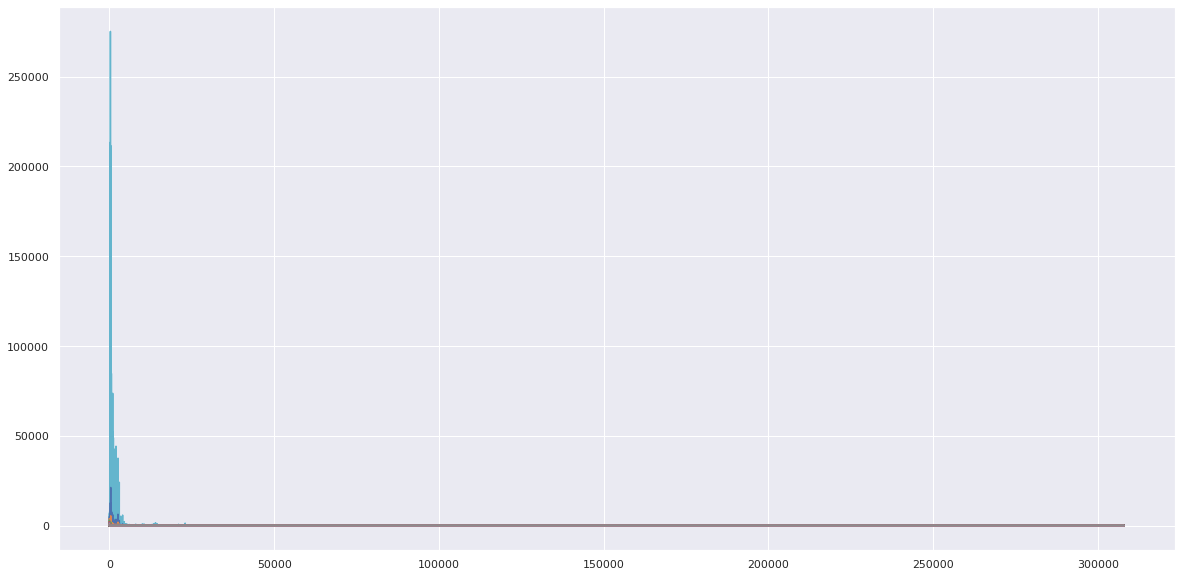

In [ ]:
# plotting clusters
plt.figure(figsize=(20, 10))
plt.plot(ct)
plt.show()

In [ ]:
# reshaping values to workable vector
dfx = salestrain_df.values.reshape(1, -1)
dfy = salestrain_df.values.reshape(1, -1)

In [ ]:
# WHY DELETING?

# delete part 1
#dfx = np.delete(dfx, 0)
#dfy = np.delete(dfy, 0)

In [ ]:
# WHY DELETING?

# delete part 2
#dfx = np.delete(dfx, 1)
#dfy = np.delete(dfy, 1)

In [ ]:
print(f'dfx shape: {dfx.shape}')
print(f'dfy shape: {dfy.shape}')

dfx shape: (1, 14679245)
dfy shape: (1, 14679245)


In [ ]:
# setting variables train test split
X = dfx
y = dfy

# running logistic regression baseline
#logreg =  LogisticRegression()
#X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# checking train, test shapes
#print(f'X_train shape: {X_train.shape}')
#print(f'y_train shape: {y_train.shape}')
#print(f'X_test shape: {X_test.shape}')
#print(f'y_test shape: {y_test.shape}')

In [ ]:
#
#logreg.fit(X_train, y_train)
#y_pred =logreg.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

In [ ]:
#clf = linear_model.Lasso(alpha=0.1)
#clf.fit(X_train, y_train)
#clf.predict(X_test)
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

## Categorical features
Created different datasets with OHE encoding, mean/target encoding, frequency encoding and hash encoding

#### OHE
OHE does not work, memory issue due to the fact that there are 22150 unique item names.

In [ ]:
# item_name unique 22150 values --> colossal number of columns, not the best option since shape will be (2935846, 21787)
cols_to_encode = ['item_category_name', 'shop_name']
salestrain_df_ohe = salestrain_df_combined.copy()

# change float64 to float16 and int64 to int16 to reduce memory usage
salestrain_df_ohe['item_price'] = salestrain_df_ohe['item_price'].astype(np.float16)
cols_int = salestrain_df_ohe.select_dtypes('int64').columns
for col in cols_int:
    salestrain_df_ohe[col] = salestrain_df_ohe[col].astype(np.int16)

# OHE
salestrain_df_ohe = pd.get_dummies(salestrain_df_ohe, prefix=['item_category_name', 'shop_name'], columns=['item_category_name', 'shop_name'], dtype=np.int16)

# renaming
item_cat_iter = 0
shop_iter = 0
for col in salestrain_df_ohe.columns:
    if col.startswith('item_category_name_'):
        salestrain_df_ohe.rename(columns={col: "item_category_name_" + str(item_cat_iter)}, inplace=True)
        item_cat_iter += 1
    if col.startswith('shop_name_'):
        salestrain_df_ohe.rename(columns={col: "shop_name_" + str(shop_iter)}, inplace=True)
        shop_iter += 1

# sounds good doesn't work: too many different categories for item_name
# cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
# for col in cols_to_encode:
#     salestrain_df_ohe = pd.get_dummies(salestrain_df_ohe, prefix=[col], columns=[col])
#     ohe_enc = OneHotEncoder()
#     ohe_enc = ohe_enc.fit_transform(salestrain_df_ohe[[col]]).astype(np.int16).toarray()
#     encoded_cols = pd.DataFrame(ohe_enc)
#     salestrain_df_ohe = pd.concat([salestrain_df_ohe, encoded_cols], axis = 1)
    
salestrain_df_ohe.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,month,day,revenue,item_category_name_0,item_category_name_1,item_category_name_2,item_category_name_3,item_category_name_4,item_category_name_5,item_category_name_6,item_category_name_7,item_category_name_8,item_category_name_9,item_category_name_10,item_category_name_11,item_category_name_12,item_category_name_13,item_category_name_14,item_category_name_15,item_category_name_16,item_category_name_17,item_category_name_18,item_category_name_19,item_category_name_20,item_category_name_21,item_category_name_22,item_category_name_23,item_category_name_24,item_category_name_25,item_category_name_26,item_category_name_27,...,shop_name_20,shop_name_21,shop_name_22,shop_name_23,shop_name_24,shop_name_25,shop_name_26,shop_name_27,shop_name_28,shop_name_29,shop_name_30,shop_name_31,shop_name_32,shop_name_33,shop_name_34,shop_name_35,shop_name_36,shop_name_37,shop_name_38,shop_name_39,shop_name_40,shop_name_41,shop_name_42,shop_name_43,shop_name_44,shop_name_45,shop_name_46,shop_name_47,shop_name_48,shop_name_49,shop_name_50,shop_name_51,shop_name_52,shop_name_53,shop_name_54,shop_name_55,shop_name_56,shop_name_57,shop_name_58,shop_name_59
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37,2013,2,1,999.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2013-04-26,3,59,944,150.0,1,2012 (BD),37,2013,4,26,150.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2013-06-26,5,59,944,199.5,1,2012 (BD),37,2013,6,26,199.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2013-07-20,6,59,944,199.5,1,2012 (BD),37,2013,7,20,199.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2013-09-14,8,59,944,299.0,2,2012 (BD),37,2013,9,14,598.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### Frequency encoder
Set categorical features to frequency they occur in the dataset

In [ ]:
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
salestrain_df_freq = salestrain_df_combined.copy()

# grouping by frequency
for col in cols_to_encode:
    freq = salestrain_df_freq.groupby(col).size()/len(salestrain_df_freq)
    salestrain_df_freq.loc[:, "{}_freq_encode".format(col)] = salestrain_df_freq[col].map(freq)
    
salestrain_df_freq.drop(columns=cols_to_encode, inplace=True)
salestrain_df_freq.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year,month,day,revenue,item_name_freq_encode,item_category_name_freq_encode,shop_name_freq_encode
0,2013-02-01,0,59,22154,999.0,1,37,2013,2,1,999.0,0.000020,0.065628,0.014343
1,2013-04-26,3,59,944,150.0,1,37,2013,4,26,150.0,0.000176,0.065628,0.014343
2,2013-06-26,5,59,944,199.5,1,37,2013,6,26,199.5,0.000176,0.065628,0.014343
3,2013-07-20,6,59,944,199.5,1,37,2013,7,20,199.5,0.000176,0.065628,0.014343
4,2013-09-14,8,59,944,299.0,2,37,2013,9,14,598.0,0.000176,0.065628,0.014343


#### Hashing
Use hash functions to translate categorical feature to numeric features



The values itself don't really say anything tbh, but the combination of the columns are mapped to one value within the original categorical feature
So for example, if you would have a categorical feature, the hash function maps this string to an X number of integers

In [ ]:
# currently, number of bits used to represent features is a bit random (2^x where the result is bigger than number of unique values)
# this takes quite a bit of time to run
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
nr_bits = [6, 7, 15]
salestrain_df_hash = salestrain_df_combined.copy()

for bits, col in zip(nr_bits, cols_to_encode):
    print(bits, col)
    h = FeatureHasher(n_features=bits, input_type='string') 
    hashed_col = h.fit_transform(salestrain_df_hash[col].astype(str)).toarray()
    salestrain_df_hash = pd.concat([salestrain_df_hash, pd.DataFrame(hashed_col)], axis = 1)
    for i in range(bits):
        salestrain_df_hash.rename(columns={i: col + "_" + str(i)}, inplace=True)
    print(col + " done")
        
salestrain_df_hash.head()

6 item_name
item_name done
7 item_category_name
item_category_name done
15 shop_name
shop_name done


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue,item_name_0,item_name_1,item_name_2,item_name_3,item_name_4,item_name_5,item_category_name_0,item_category_name_1,item_category_name_2,item_category_name_3,item_category_name_4,item_category_name_5,item_category_name_6,shop_name_0,shop_name_1,shop_name_2,shop_name_3,shop_name_4,shop_name_5,shop_name_6,shop_name_7,shop_name_8,shop_name_9,shop_name_10,shop_name_11,shop_name_12,shop_name_13,shop_name_14
0,2013-02-01,0.0,59.0,22154.0,999.0,1.0,Scene 2012 (BD),37.0,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013.0,2.0,1.0,999.0,-2.0,-1.0,2.0,2.0,0.0,0.0,2.0,0.0,3.0,-1.0,2.0,0.0,-1.0,0.0,0.0,4.0,0.0,2.0,2.0,-4.0,1.0,-1.0,-6.0,3.0,0.0,-1.0,2.0,-2.0
1,2013-04-26,3.0,59.0,944.0,150.0,1.0,2012 (BD),37.0,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013.0,4.0,26.0,150.0,0.0,-3.0,1.0,2.0,0.0,1.0,2.0,0.0,3.0,-1.0,2.0,0.0,-1.0,0.0,0.0,4.0,0.0,2.0,2.0,-4.0,1.0,-1.0,-6.0,3.0,0.0,-1.0,2.0,-2.0
2,2013-06-26,5.0,59.0,944.0,199.5,1.0,2012 (BD),37.0,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013.0,6.0,26.0,199.5,0.0,-3.0,1.0,2.0,0.0,1.0,2.0,0.0,3.0,-1.0,2.0,0.0,-1.0,0.0,0.0,4.0,0.0,2.0,2.0,-4.0,1.0,-1.0,-6.0,3.0,0.0,-1.0,2.0,-2.0
3,2013-07-20,6.0,59.0,944.0,199.5,1.0,2012 (BD),37.0,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013.0,7.0,20.0,199.5,0.0,-3.0,1.0,2.0,0.0,1.0,2.0,0.0,3.0,-1.0,2.0,0.0,-1.0,0.0,0.0,4.0,0.0,2.0,2.0,-4.0,1.0,-1.0,-6.0,3.0,0.0,-1.0,2.0,-2.0
4,2013-09-14,8.0,59.0,944.0,299.0,2.0,2012 (BD),37.0,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013.0,9.0,14.0,598.0,0.0,-3.0,1.0,2.0,0.0,1.0,2.0,0.0,3.0,-1.0,2.0,0.0,-1.0,0.0,0.0,4.0,0.0,2.0,2.0,-4.0,1.0,-1.0,-6.0,3.0,0.0,-1.0,2.0,-2.0


#### Target/mean encoding
Seems to work very well in lots of applications, but can cause overfitting. Maybe use (stratified) KFold?

In [ ]:
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
salestrain_df_mean = salestrain_df_combined.copy()

# simple method, probably should do this with item_cnt_month though, should create that feature
for col in cols_to_encode:
    mean_enc = salestrain_df_mean.groupby(col)['item_cnt_day'].mean()
    salestrain_df_mean.loc[:, str(col + "_mean_encoded")] = salestrain_df_mean[col].map(mean_enc)
    
salestrain_df_mean.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue,item_name_mean_encoded,item_category_name_mean_encoded,shop_name_mean_encoded
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0,1.000000,1.055067,1.163508
1,2013-04-26,3,59,944,150.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,4,26,150.0,1.005803,1.055067,1.163508
2,2013-06-26,5,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,26,199.5,1.005803,1.055067,1.163508
3,2013-07-20,6,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,7,20,199.5,1.005803,1.055067,1.163508
4,2013-09-14,8,59,944,299.0,2,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,9,14,598.0,1.005803,1.055067,1.163508


# DBSCAN (and other clustering)


In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
# creating DBSCAN data copy
salestrain_DBSCAN = salestrain_df_combined.copy()
X = salestrain_DBSCAN['date']
y = salestrain_DBSCAN['revenue']


salestrain_DBSCAN = salestrain_DBSCAN.drop(columns=['date'])

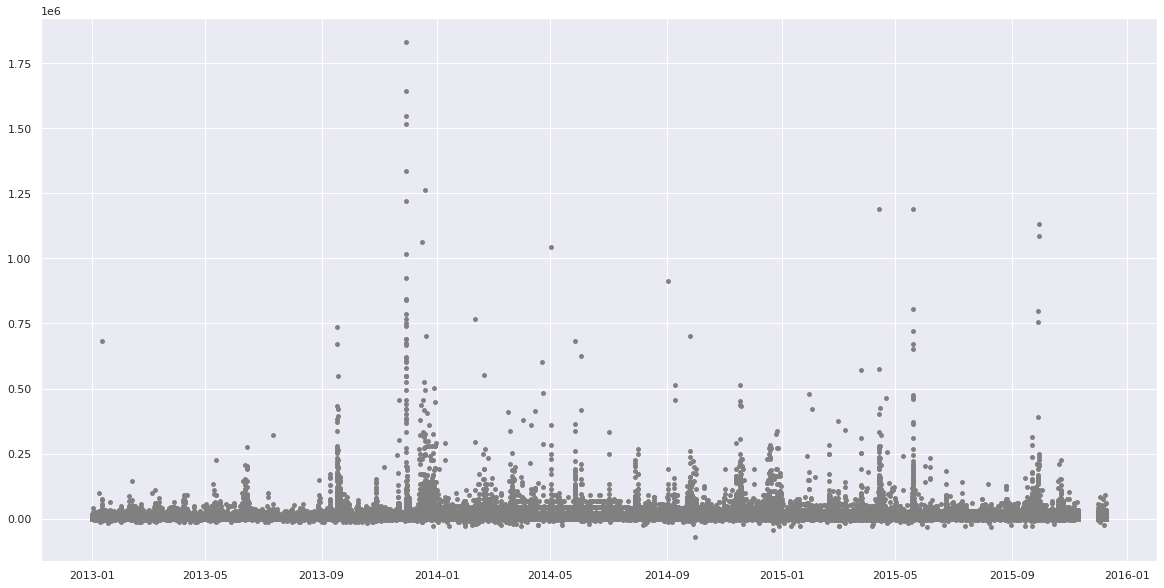

In [ ]:
# showing sales pre clustering
plt.figure(figsize=(20,10))
plt.scatter(X, y, s=15, color='grey')
plt.show()

TRY CLUSTERING PART 2 WITH MITCHELLS CATEGORICAL HASHING 

In [ ]:
#salestrain_df_hash.head()
salestrin_DBSCAN = salestrain_df_hash.drop(columns=['date', 'item_name', 'item_category_name','shop_name'], axis=1)
salestrain_DBSCAN.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
0,0,59,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0
1,3,59,944,150.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,4,26,150.0
2,5,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,26,199.5
3,6,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,7,20,199.5
4,8,59,944,299.0,2,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,9,14,598.0


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(salestrain_DBSCAN)

ValueError: ignored

In [ ]:
k_means = KMeans(n_clusters=4, random_state=42)
k_means.fit(salestrain_DBSCAN[0,1])

need to determine 2 things with DBSCAN, epsilon and minPoints


# good resources

dbscan!

https://www.google.com/search?q=dbscan+python&sxsrf=ALeKk01MOpqS6o2Y-gJotJVswEPIS6thPA%3A1616814191706&ei=b6BeYL68KsKHggfYxrfgDw&oq=dbscan&gs_lcp=Cgdnd3Mtd2l6EAMYAjIECCMQJzIECAAQQzIECAAQQzIECAAQQzIECAAQQzIECAAQQzIHCAAQsQMQQzICCAAyBAgAEEMyAggAOgoILhDHARCvARBDOgoILhDHARCjAhBDOggILhCxAxCDAToNCC4QsQMQxwEQowIQQzoKCAAQsQMQgwEQQ1DFalilcmDHiwFoAHACeACAAdYLiAHZFZIBDTAuNC4xLjUtMS4wLjGYAQCgAQGqAQdnd3Mtd2l6wAEB&sclient=gws-wiz

https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

https://www.geeksforgeeks.org/implementing-dbscan-algorithm-using-sklearn/

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

aws colab integration

https://medium.com/@lily_su/accessing-s3-bucket-from-google-colab-16f7ee6c5b51

https://python.plainenglish.io/how-to-load-data-from-aws-s3-into-google-colab-7e76fbf534d2

https://stackoverflow.com/questions/50978361/how-to-load-s3-open-dataset-in-google-colaboratory